# [3-tuning] - Parametrages de hyperparamètres

## Import des modules
> cf. [pyproject.toml](pyproject.toml) pour connaître les librairies à installer

In [39]:
import io
import os
import boto3
import joblib
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

## Récupération des données dans le stockage objet AWS S3

In [2]:
# Configutations S3 access and data
load_dotenv()
aws_access_key_id = os.getenv('aws_access_key_id')
aws_secret_access_key = os.getenv('aws_secret_access_key')

In [3]:
# S3 connection
s3 = boto3.client(
    service_name = "s3",
    region_name = "eu-west-3",
    aws_access_key_id = aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key,
)

In [4]:
# Specific bucket data
bucket_name = "hotel-resa-prediction"
prefix = "datasets/"
filename = "processed_hotel_bookings.csv"

In [5]:
# get datas 
result = s3.list_objects(Bucket=bucket_name)
for obj in result.get('Contents'):
    if (obj["Key"].startswith(prefix)) and (obj["Key"].endswith(filename)):
        data = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        contents = data['Body'].read().decode("utf-8")
        data = pd.read_csv(io.StringIO(contents), low_memory=False)

## Préparation des données pour l'ingestion dans la pipeline de machine learning

In [6]:
X = data.drop("is_canceled",  axis=1)
y = data["is_canceled"]
print("Features : ", X.shape)
print("Target : ", y.shape) # s'assurer de n'avoir qu'une colonne ici

Features :  (119210, 30)
Target :  (119210,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    shuffle=True, 
    stratify=y # IMPORTANT pour bien balancer les prédictions première itération --> courbe ROC mauvais 
)
print("Features train : ", X_train.shape)
print("Target train : ", y_train.shape)
print("Features test : ", X_test.shape)
print("Target test : ", y_test.shape)

Features train :  (83447, 30)
Target train :  (83447,)
Features test :  (35763, 30)
Target test :  (35763,)


## Récupération du modèle dans le stockage objet AWS S3

In [8]:
prefix_model = "models/"
filename_model = "hotel_bookings_churn_model.pkl"

In [9]:
result_model = s3.list_objects(Bucket=bucket_name)
for obj in result_model.get('Contents'):
    if (obj["Key"].startswith(prefix_model)) and (obj["Key"].endswith(filename_model)):
        model = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        model_content = model['Body'].read()
        model_pipeline = joblib.load(io.BytesIO(model_content))

## Affinage du modèle
> Précédemment, nous avons fait une comparaison par GridSearch et CrossValidation pour trouver le meilleur modèle de machine learning pour cette problématique de classification sans toucher aux hyperparamètres
> Actuellement, nous allons nous occupé d'affiner les hyperparamètres du modèle pour avoir une meilleure performance. 

Pour se faire, nous allons utiliser le RandomizedSearchCV soit une validation croisée avec des échantillonnés aléatoirement dans un espace défini, permettant une exploration plus rapide qu'une recherche exhaustive. (un premier test trop lent a été réalisé avec GridSearchCV). 

**Affichage du modèle :**

In [10]:
model_pipeline

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Info :**
Récupération des hyperparamètre à affiner en fonction des éléments dans la [documentation scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) l'idée est de faire une sélection en prenant en compte la puissance de calcul de la machine à disposition.

In [11]:
params_distrib = {
    "gradientboostingclassifier__n_estimators": [100, 200, 300],
    "gradientboostingclassifier__max_depth": [3, 5, 7],
    "gradientboostingclassifier__learning_rate": [0.05, 0.1, 0.2],
    "gradientboostingclassifier__subsample": [0.8, 1.0],
    "gradientboostingclassifier__max_features": ["sqrt", None],
    "gradientboostingclassifier__min_samples_split": [5, 10],
    "gradientboostingclassifier__min_samples_leaf": [1, 5]
}

**Info** : paramétrage de la validation croisée avec des échantillon aléatoire. Ici, on prend l'accuracy en méthode de scoring pour la sélection. L'idée est de faire 3 croisement et paraléliser les calculs avec `n_jobs=-1`

In [12]:
search_cv = RandomizedSearchCV(
    model_pipeline,
    param_distributions=params_distrib,
    n_iter=50,  
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    error_score='raise'
)

In [13]:
search_cv.fit(X_train, y_train) 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'gradientboostingclassifier__learning_rate': [0.05, 0.1, ...], 'gradientboostingclassifier__max_depth': [3, 5, ...], 'gradientboostingclassifier__max_features': ['sqrt', None], 'gradientboostingclassifier__min_samples_leaf': [1, 5], ...}"
,n_iter,50
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,'raise'


In [14]:
cv_results = search_cv.cv_results_ 

In [15]:
pd.DataFrame(cv_results).sort_values(by="rank_test_score", ascending=True).head(3) 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__subsample,param_gradientboostingclassifier__n_estimators,param_gradientboostingclassifier__min_samples_split,param_gradientboostingclassifier__min_samples_leaf,param_gradientboostingclassifier__max_features,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,179.679283,1.026761,1.746729,0.241010,0.8,300,5,5,None,7,0.2,"{'gradientboostingclassifier__subsample': 0.8,...",0.873957,0.872340,0.878806,0.875034,0.002748,1
20,161.831660,1.770651,1.713367,0.097976,0.8,300,10,5,None,7,0.1,"{'gradientboostingclassifier__subsample': 0.8,...",0.872340,0.871189,0.875175,0.872901,0.001675,2
19,159.982683,0.650914,1.372904,0.020630,0.8,300,5,5,None,7,0.1,"{'gradientboostingclassifier__subsample': 0.8,...",0.872519,0.871117,0.875067,0.872901,0.001635,3


**Conclusions :** Quand on augmente le n_estimators, le score du modèle devient meilleur. Le modèle apprend donc mieux avec plus d’arbres. Une grand max_depth, comme 7, donne de bons résultats. Ça veut dire que le modèle a besoin de bien creuser pour repérer les bons motifs. Un learning_rate plus élevé (0.2) marche bien ici. Le modèle apprend plus vite et ça lui réussit. Un subsample à 0.8 (au lieu de 1.0) donne de meilleurs scores. Laisser un peu de hasard aide à éviter que le modèle s’adapte trop aux données. Les meilleurs scores sont avec min_samples_split et min_samples_leaf à 5. Donc, laisser le modèle créer plus facilement des divisions dans les arbres semble être un bon choix ici.

In [16]:
best_model = search_cv.best_estimator_
best_model

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [17]:
result = best_model.predict(X_test) 

In [ ]:
accuracy = accuracy_score(y_test, result)
precision = precision_score(y_test, result)
recall = recall_score(y_test, result)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [31]:
print(f"The accuracy score : {accuracy*100:.3f}%")
print(f"The precision score: {precision*100:.3f}%")
print(f"The recall score: {recall*100:.3f}%")
print(f"The ROC AUC score: {roc_auc*100:.3f}%")

The accuracy score : 87.988%
The precision score: 86.041%
The recall score: 80.694%
The ROC AUC score: 94.885%


**Conclusion :**
- Accuracy : montre que le modèle le modèle fait presque 88 bonnes prédictions sur 100.
- Precision : Quand le modèle prédit une annulation, il a raison dans 86 % des cas. Il évite donc plutôt bien les fausses alertes.
- Recall : montre que le modèle détecte environ 81 % des vraies annulations. Cela signifie qu’il en rate encore quelques-unes (faux négatifs).
- ROC AUC : Le modèle est très bon pour distinguer les cas d’annulation des autres. Un score proche de 100 % montre une excellente capacité de séparation.

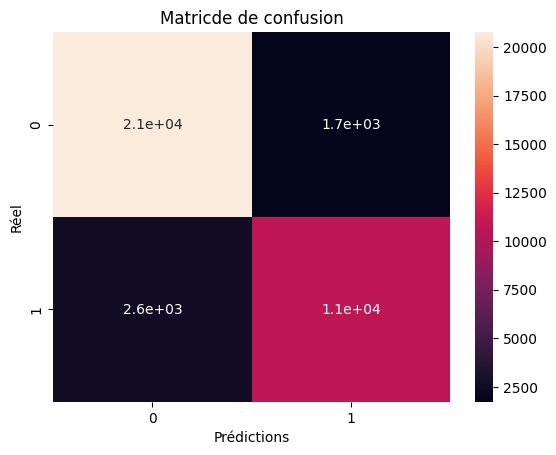

In [ ]:
confusion_matrix = confusion_matrix(y_test, result) 
_ = sns.heatmap((confusion_matrix), annot=True).set(title="Matrice de confusion", xlabel="Prédictions", ylabel="Réel") 

**Conclusion :**
Le modèle fait très peu d’erreurs dans l’ensemble. Il reconnaît bien les annulations (avec plus de 11 000 bonnes prédictions) mais en rate encore environ 2 600, ce qui correspond au recall d'environ 81 % vu plus tôt.

/var/folders/6j/prwx2hms3hzdtbw453ddk_k40000gn/T/ipykernel_7576/3567004493.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


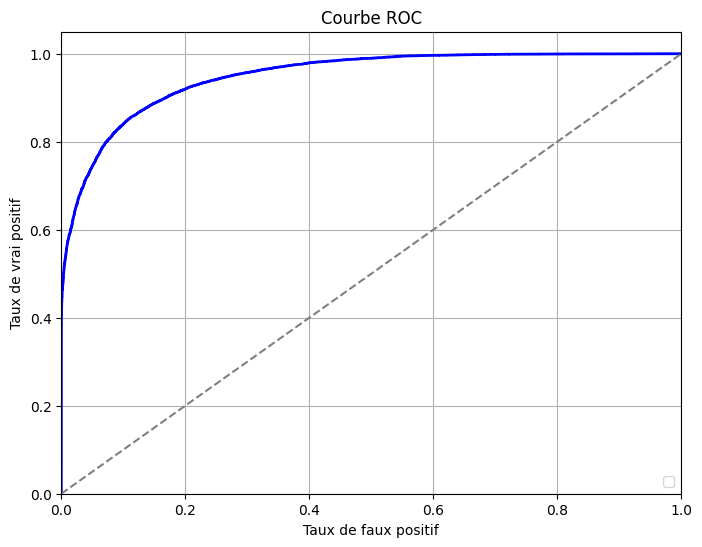

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taux de faux positif")
plt.ylabel("Taux de vrai positif")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Conclusion :** la courbe ROC monte presque directement vers le coin supérieur gauche, nettement au-dessus de la diagonale hasard, ce qui montre que le modèle sépare très efficacement les réservations annulées des non-annulées.<br>
**Décision :** nous conservons le seuil actuel 0,50 afin de limiter les fausses alertes, cela évite de déclencher à tort le futur filtre dans le formulaire de réservation tout en atteignant l’objectif métier principal : réduire les annulations réelles et donc les pertes de revenu.

In [ ]:
prefix = "models/"
filename_model = "finetuned_hotel_bookings_churn_model.pkl"

In [ ]:
# try:
#     os.makedirs(prefix, exist_ok=True)
#     joblib.dump(ensemble_pipeline, prefix + filename_model)
#     print(f"Modèle optimal enregistré avec succès ({best_models[0]}) sous le nom {filename_model}.")
# except Exception as e:
#     print(f"Erreur lors du téléversement du modèle : {e}")

-- END --